# Real-time predictions of Dota match outcome

#### In this notebook we are going to present a simple real-time prediction on a particular window of 5-minutes using Logistic Regression.

#### Library Imports

In [16]:
import pandas as pd
import numpy as np

# plot libraries
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# models, metrics and transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score

# interactive viz
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

In [2]:
plt.style.use('default')


#### Data Imports
The dataset can be found [here](https://www.kaggle.com/devinanzelmo/dota-2-matches)!


In [17]:
time_df = pd.read_csv('../data/player_time.csv')
matches_df = pd.read_csv("../data/match.csv")
player_df = pd.read_csv("../data/players.csv")

matches_df.set_index('match_id');

In [4]:
time_df.head(4)

,match_id,times,gold_t_0,lh_t_0,xp_t_0,gold_t_1,lh_t_1,xp_t_1,gold_t_2,lh_t_2,...,xp_t_129,gold_t_130,lh_t_130,xp_t_130,gold_t_131,lh_t_131,xp_t_131,gold_t_132,lh_t_132,xp_t_132
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,60,409,0,63,142,1,186,168,0,...,62,345,6,351,100,0,77,613,1,125
2,0,120,546,0,283,622,4,645,330,0,...,543,684,12,805,200,0,210,815,5,323
3,0,180,683,1,314,927,9,1202,430,0,...,842,958,16,1135,300,0,210,1290,8,527


The playtime history seems to be given in times as a columns, so the match_id is repeated for the number of minutes of the game. In order to extract it, we can pivot the table and make the different times our new columns, so that the match_id is an unique identifier in the table.

### Helper methods

In [18]:
# todo: move those in a separate module
RAD_GLD_COLS = [f'gold_t_{i}' for i in range(0, 5)]
DIR_GLD_COLS = [f'gold_t_{i}' for i in range(128, 133)]

RAD_XP_COLS = [f'xp_t_{i}' for i in range(0, 5)]
DIR_XP_COLS = [f'xp_t_{i}' for i in range(128, 133)]

def get_mean_gold_difference(df):
    return df[RAD_GLD_COLS].mean(axis=1) - df[DIR_GLD_COLS].mean(axis=1)

def get_mean_xp_difference(df):
    return df[RAD_XP_COLS].mean(axis=1) - df[DIR_XP_COLS].mean(axis=1)

### Data Preprocessing and feature extraction


In [19]:
# mean gold difference is the meaned gold of the radiant team minus the mean gold of the dire team
time_df['mean_gold_diff'] = get_mean_gold_difference(time_df)
time_df['mean_xp_diff'] = get_mean_xp_difference(time_df)

# set time and join with radiant win
time_df['times'] = pd.to_datetime(time_df['times'], unit='s') # turn the seconds to real time
gold_diff_df = time_df.pivot(index='match_id', columns='times', values='mean_gold_diff')
xp_diff_df = time_df.pivot(index='match_id', columns='times', values= 'mean_xp_diff')

# standardize the data
std_scaler = StandardScaler()
gold_diff_std_df = pd.DataFrame(std_scaler.fit_transform(gold_diff_df), columns=gold_diff_df.columns)
xp_diff_std_df = pd.DataFrame(std_scaler.fit_transform(xp_diff_df), columns=gold_diff_df.columns)


### Explore correlation between mean gold difference and mean xp difference of the teams

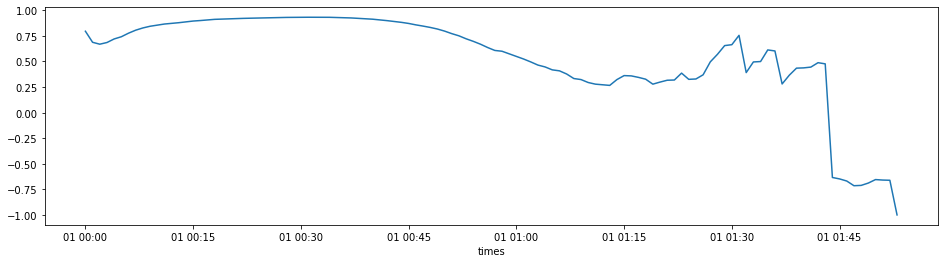

In [21]:
# corelation between gold and experience by particular minute
figure = plt.figure(figsize=(16, 4))
gold_xp_time_correlations = gold_diff_df.corrwith(xp_diff_df, drop=True)
sns.lineplot(x=gold_xp_time_correlations.index, y=gold_xp_time_correlations);

We see high correlation between the mean gold difference and the mean xp difference which should mean that only one of the predictors should be enough for fitting a model

## Explore the predictors on a particular minute

In [22]:
@widgets.interact()
def show_match(match=(1, 400)):
    date_form = DateFormatter("%M")
    plt.figure(figsize=(20, 6))
    plt.grid(True)

    # select a match on a particular id in the slider
    some_match = time_df[time_df['match_id'] == match]
    does_win = matches_df.at[match, 'radiant_win']
    winner = 'Radiant' if does_win else 'Dire'

    # line plots for the mean gold difference and the mean experience difference
    g1 = sns.lineplot(data=some_match, y='mean_gold_diff', x='times', label='Teams Mean Gold Different')
    g2 = sns.lineplot(data=some_match, y='mean_xp_diff', x='times', label='Teams Mean Experience Different')

    # set the labels on the plot    
    g1.xaxis.set_major_formatter(date_form)
    g1.set(xlabel=f'minutes \ {winner} wins', ylabel='Radiant \ Dire Gold and Experience Difference');
    return match

interactive(children=(IntSlider(value=200, description='match', max=400, min=1), Output()), _dom_classes=('wid…

### Distribution plot on the gold difference at a particular minute

In [23]:
@widgets.interact()
def plot_mean_gold_difference(minute = (1, 60)):
    sns.distplot(gold_diff_std_df.iloc[:, minute])
    return minute

interactive(children=(IntSlider(value=30, description='minute', max=60, min=1), Output()), _dom_classes=('widg…

Looks like the gold follows a Student's  t-distribution.

## Logistic regression on a time window of 5 minutes

We are going to train a Logistic Regression on a five minutes window. In order to predict the nth minute we feed the model a the gold features on the 5 minutes before the nth minute.

In [24]:
def train(X_train, y_train, minute, model = LogisticRegression()):
    ncols = X_train.shape[1]
    start = max(0, minute - 6)
    end = min(ncols - 1, minute - 1)

    is_present = -X_train.iloc[:, start:end].isna().any(axis=1)

    return model.fit(X_train[is_present].iloc[:, start:end], y_train[is_present])

In [25]:

# split the data to train and test sets
outcome = matches_df[['radiant_win']]
X_train, X_test, y_train, y_test = train_test_split(gold_diff_std_df, outcome, test_size=0.8, random_state=1)

# game minutes on which to test the model for prediction of a particular minute
nones = np.repeat(None, 5) # add nones to the models before the fifth minute for better indexing
fitted_models = np.append(nones, [train(X_train, y_train, minute) for minute in range(6, 60)]) # models trained on minutes 1

## Probability of winning visualization


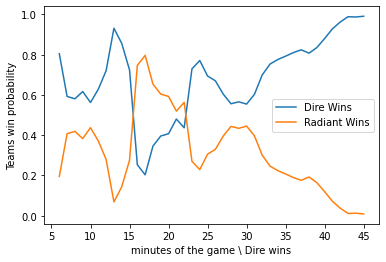

In [26]:
# prepare the test match to show it's probablities of winning for both Radiant and Dire teams
MATCH_ID_TO_TEST = 1

test_match = X_test[X_test.index == MATCH_ID_TO_TEST].dropna(axis=1)
times_index = range(6, test_match.shape[1])
# prepare the dataframe of the winning probabilities
probs_arr = [fitted_models[i].predict_proba(test_match.iloc[:, i-6:i-1].dropna(axis=1))[0] for i in times_index]
probs_df = pd.DataFrame(probs_arr, columns=['dire_win_probability', 'radiant_win_probability'])

# plot the results
g1 = sns.lineplot(data=probs_df, y='dire_win_probability', x=times_index, label='Dire Wins')
g2 = sns.lineplot(data=probs_df, y='radiant_win_probability', x=times_index, label='Radiant Wins')

# show the winner in the X-axis description
does_win = matches_df.loc[MATCH_ID_TO_TEST, 'radiant_win']
winner = 'Radiant' if does_win else 'Dire'
g1.set(xlabel=f'minutes of the game \ {winner} wins', ylabel='Teams win probability');

### Model Assessment for a particular minute

In [27]:
@widgets.interact()
def show_roc(minute=(6, 50)):
    # test data on the five minutes interval before the minute we are trying to predict
    test_data = X_test.iloc[:, minute-6:minute-1]
    isna_mask = test_data.isna().any(axis=1)
    
    plot_roc_curve(fitted_models[minute], test_data[-isna_mask], y_test[-isna_mask]);


interactive(children=(IntSlider(value=28, description='minute', max=50, min=6), Output()), _dom_classes=('widg…

We see that the model predicts best at the middle of the match, while at the beginning and end it does not perform so well. Using the same methodology for experience we see that the gold feature gives far better results for AUC. Since they are colinear in most of the game, we can use just the gold for the five past minutes.

## Conditional Markov chain model of bin transitions (WIP)
#####  also known as Abstract Sequence Model (ASM)
An alternative approach would be to discretize the gold through the games into different bins and construct a conditional Markov Chain model given that the winner is the Radiant or the Dire team. We than explore the trajectory of a particular match to determine to which situation it is more likely, to a radiant win or to a dire win.

In [273]:
@widgets.interact()
def show_hist_of_winners(minute = (1, 100), radiant_wins = [True, False], feature = ['Gold', 'Experience']):
    df = gold_diff_std_df if feature == 'Gold' else xp_diff_std_df
    mask = matches_df['radiant_win'] == radiant_wins

    ts_to_show = df[mask].iloc[:, minute]
    g = sns.distplot(ts_to_show)
    g.set(xlabel=f'mean is {round(ts_to_show.mean(), 4)}', ylabel='Teams win probability');

interactive(children=(IntSlider(value=50, description='minute', min=1), Dropdown(description='radiant_wins', o…

In [356]:
# prepare the transition matrix
bins = np.linspace(-4, 4, 21)
labels = list(range(1, 21))

# turn the a time series object to bins 
first_row_binned = pd.cut(gold_diff_std_df.iloc[0, :], bins=bins, labels=labels)

# todo: move that function to a module
# todo: find a way to optimize optimize this code (very slow), restructure it, reformat it
def construct_transition_matrix(ts):
    df = pd.DataFrame(columns=['B'])
    df['B'] = ts

    elements = sorted(df['B'].unique())
    
    df['C'] = df.shift(-1)

    groups = df.groupby(['B', 'C'])
    counts = {i[0]:(len(i[1]) if i[0][0] != i[0][1] else 0) for i in groups}

    matrix = pd.DataFrame(columns=labels, index=labels)

    for x in elements:
        matrix[x] = pd.Series([counts.get((x, y), 0) for y in elements], index=elements)

    return matrix.fillna(0)

winners = gold_diff_std_df[matches_df['radiant_win']]

# accumulate a frequency matrix of transitions from one bin to another
transition_matrix = construct_transition_matrix(first_row_binned)
for i in range(1, winners.shape[0]):
    curr = pd.cut(winners.iloc[i, :], bins=bins, labels=labels)
    transition_matrix += construct_transition_matrix(curr)


### A Heatmap showing the transition probabilities of the Markov Chain

<AxesSubplot:>

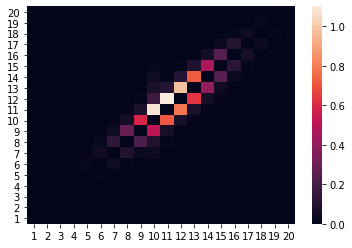

In [402]:
transition_matrix.columns = np.array(transition_matrix.columns).astype(int)
sns.heatmap((transition_matrix.iloc[::-1, :20]))


#### Next Steps: 
* Optimize the transition matrix construction (algorithm is too slow)
* Make a prediction with this model
* Model Assessment and compare with the logistic regression model

#### Some Ideas:
* The gold distribution follows a t-distribution which is similar to the Gaussian one. They are both t-distributed but with different mean. Maybe try LDA for the time window and test the model

### References:
[Real-time eSports Match Result Prediction](https://arxiv.org/abs/1701.03162)